# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [25]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [38]:
# loading the data:
customers = pd.read_csv('../Wholesale customers data.csv')

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [3]:
# Your code here:
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
customers.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

In [5]:
customers.isna().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [6]:
customers.corr()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,1.000000,0.062028,-0.169172,0.460720,0.608792,-0.202046,0.636026,0.056011
Region,0.062028,1.000000,0.055287,0.032288,0.007696,-0.021044,-0.001483,0.045212
Fresh,-0.169172,0.055287,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.460720,0.032288,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,0.608792,0.007696,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,-0.202046,-0.021044,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,0.636026,-0.001483,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,0.056011,0.045212,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


<ipython-input-13-a322ce45369d>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(customers.corr(), dtype = np.bool))


Text(0.5, 1.0, 'Triangle Correlation Heatmap')

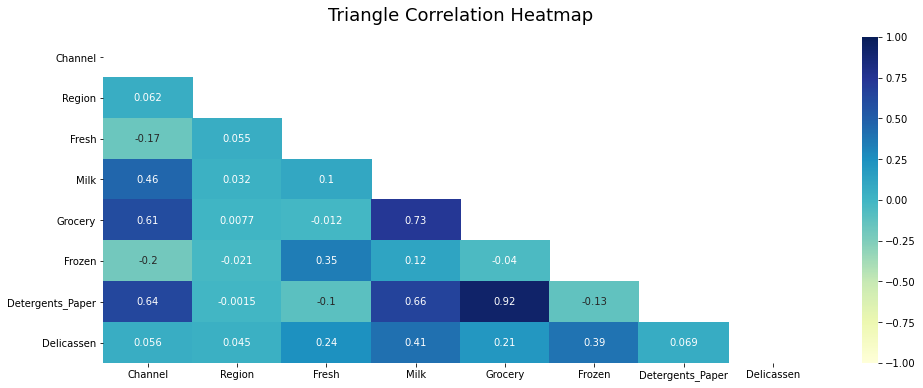

In [13]:
plt.figure(figsize = (16, 6))
mask = np.triu(np.ones_like(customers.corr(), dtype = np.bool))
heatmap = sns.heatmap(customers.corr(), mask = mask, vmin = -1, vmax = 1, 
                      annot = True, cmap = 'YlGnBu')
heatmap.set_title('Triangle Correlation Heatmap', fontdict = {'fontsize':18}, pad = 16)

In [8]:
customers.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


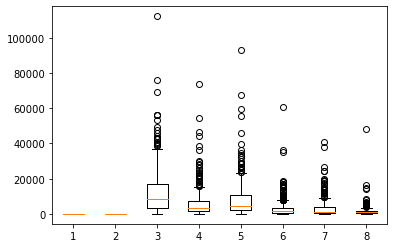

In [11]:
plt.boxplot(customers)
plt.show()

In [14]:
customers['Channel'].value_counts()

# Horeca 1
# Retail 2

1    298
2    142
Name: Channel, dtype: int64

In [15]:
customers['Region'].value_counts()

# Lisbon 1
# Porto 2
# Other Region 3

3    316
1     77
2     47
Name: Region, dtype: int64

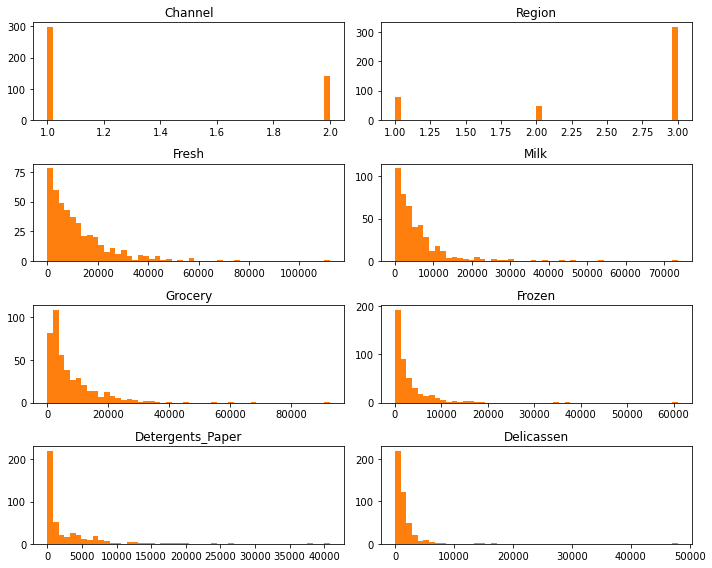

In [16]:
plot_options, charts = plt.subplots(4, 2, figsize = (10, 8))
charts_1d = charts.ravel()
for i in range(8):
    charts_1d[i].hist(customers.iloc[:, i], bins = 50)
    charts_1d[i].hist(customers.iloc[:, i], bins = 50)
    charts_1d[i].set_title(customers.columns[i])
    plot_options.tight_layout()

In [ ]:
# Your observations here
'''
What does each column mean?

Attribute Information:

1) FRESH: annual spending (m.u.) on fresh products (Continuous);
2) MILK: annual spending (m.u.) on milk products (Continuous);
3) GROCERY: annual spending (m.u.) on grocery products (Continuous);
4) FROZEN: annual spending (m.u.) on frozen products (Continuous)
5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
6) DELICATESSEN: annual spending (m.u.) on and delicatessen products (Continuous);
7) CHANNEL: customers Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal)
8) REGION: customers Region: Lisnon, Porto or Other (Nominal)

Any categorical data to convert?

No, we have all data as integer. Even our labels are incoded by numbers

Any missing data to remove?

No, there are no nulls.

Column collinearity - any high correlations?

Yes, columns GROCERY and DETERGENTS_PAPER are highly correlated.
Also columns GROCERY and MILK, DETERGENTS_PAPER and MILK, but less.

Descriptive statistics - any outliers to remove?

We have some outliers on every column. For now will let it stay to see how it affects our data.

Column-wise data distribution - is the distribution skewed?

All the data is positive skewed
'''

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [39]:
# Your code here

customers = pd.get_dummies(customers, columns = ['Channel','Region'])
customers = customers.rename(columns = {'Channel_1': 'Horeca', 
                                                    'Channel_2': 'Retail',
                                                    'Region_1': 'Lisbon',
                                                    'Region_2': 'Porto', 
                                                    'Region_3': 'Other region'}, 
                                         inplace = False)

customers

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Horeca,Retail,Lisbon,Porto,Other region
0,12669,9656,7561,214,2674,1338,0,1,0,0,1
1,7057,9810,9568,1762,3293,1776,0,1,0,0,1
2,6353,8808,7684,2405,3516,7844,0,1,0,0,1
3,13265,1196,4221,6404,507,1788,1,0,0,0,1
4,22615,5410,7198,3915,1777,5185,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204,1,0,0,0,1
436,39228,1431,764,4510,93,2346,1,0,0,0,1
437,14531,15488,30243,437,14841,1867,0,1,0,0,1
438,10290,1981,2232,1038,168,2125,1,0,0,0,1


In [ ]:
# Your comment here

'''
I choose to create dummies for my categorical data and rename the column to understand what they
exactly means. For now that's all
'''

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [40]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:

scaler = StandardScaler()
scaler.fit(customers)
customers_scale = scaler.transform(customers)

# Challenge 4 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [41]:
# Your code here:

kmeans = KMeans(random_state = 0).fit(customers_scale)
customers['labels_kmeans'] = kmeans.labels_
customers.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Horeca,Retail,Lisbon,Porto,Other region,labels_kmeans
0,12669,9656,7561,214,2674,1338,0,1,0,0,1,2
1,7057,9810,9568,1762,3293,1776,0,1,0,0,1,2
2,6353,8808,7684,2405,3516,7844,0,1,0,0,1,2
3,13265,1196,4221,6404,507,1788,1,0,0,0,1,0
4,22615,5410,7198,3915,1777,5185,0,1,0,0,1,2


Count the values in `labels`.

In [42]:
# Your code here:
customers['labels_kmeans'].value_counts()

0    171
2    107
1     65
3     40
4     27
7     18
5     11
6      1
Name: labels_kmeans, dtype: int64

# Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [43]:
# Your code here

dbscan = DBSCAN(eps = 0.5).fit(customers_scale)
customers['labels_DBSCAN'] = dbscan.labels_

Count the values in `labels_DBSCAN`.

In [44]:
# Your code here

customers['labels_DBSCAN'].value_counts()

-1    255
 1    130
 5     22
 4      7
 6      6
 2      5
 3      5
 7      5
 0      5
Name: labels_DBSCAN, dtype: int64

# Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Detergents_Paper', ylabel='Milk'>

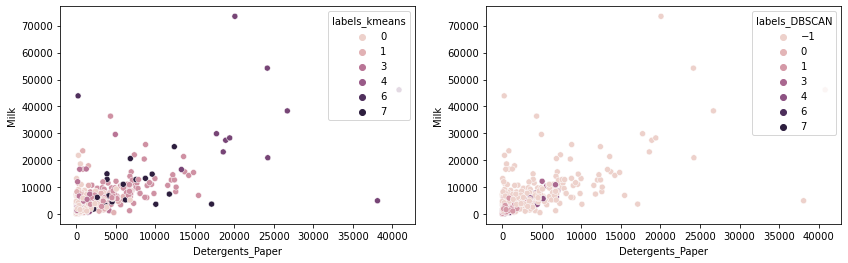

In [45]:
# Your code here:

fig, ax = plt.subplots(1, 2, figsize = (14,4))
sns.scatterplot(customers['Detergents_Paper'], customers['Milk'], 
                hue = customers['labels_kmeans'], data = customers, ax = ax[0])
sns.scatterplot(customers['Detergents_Paper'], customers['Milk'], 
                hue = customers['labels_DBSCAN'], data = customers, ax = ax[1])

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Grocery', ylabel='Fresh'>

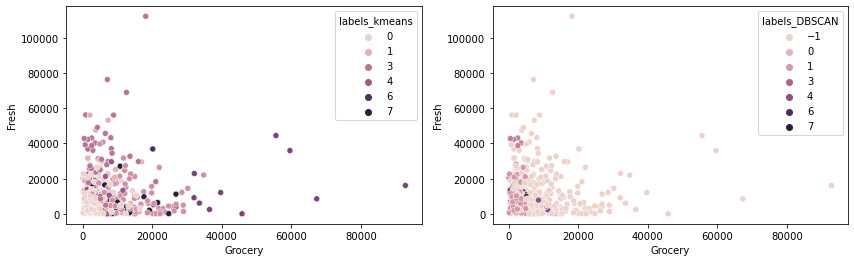

In [46]:
# Your code here:

fig, ax = plt.subplots(1, 2, figsize = (14,4))
sns.scatterplot(customers['Grocery'], customers['Fresh'], 
                hue = customers['labels_kmeans'], data = customers, ax = ax[0])
sns.scatterplot(customers['Grocery'], customers['Fresh'], 
                hue = customers['labels_DBSCAN'], data = customers, ax = ax[1])

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Frozen', ylabel='Delicassen'>

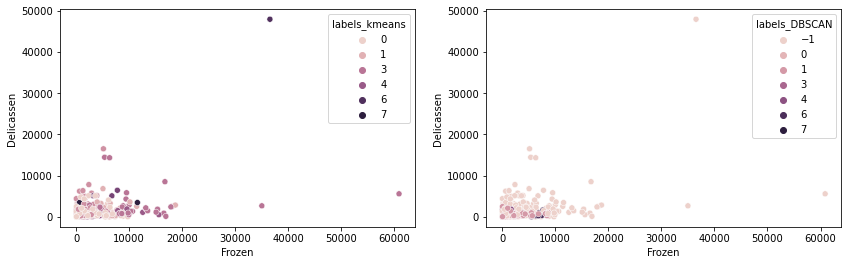

In [47]:
# Your code here:

fig, ax = plt.subplots(1, 2, figsize = (14,4))
sns.scatterplot(customers['Frozen'], customers['Delicassen'], 
                hue = customers['labels_kmeans'], data = customers, ax = ax[0])
sns.scatterplot(customers['Frozen'], customers['Delicassen'], 
                hue = customers['labels_DBSCAN'], data = customers, ax = ax[1])

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [48]:
# Your code here:

customers.groupby('labels_kmeans').mean()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Horeca,Retail,Lisbon,Porto,Other region,labels_DBSCAN
labels_kmeans,,,,,,,,,,,,
0,9068.842105,2989.432749,3448.959064,2201.099415,772.725146,1000.970760,1.000000,0.000000,0.000000,0.000000,1.000000,0.508772
1,12357.030769,4017.907692,4391.969231,3156.769231,1168.907692,1200.938462,0.907692,0.092308,1.000000,0.000000,0.000000,1.676923
2,8694.560748,8930.766355,14066.841121,1440.448598,5874.943925,1767.579439,0.000000,1.000000,0.084112,0.000000,0.915888,-0.439252
3,34334.175000,4934.850000,5594.625000,10488.825000,872.175000,2671.450000,1.000000,0.000000,0.000000,0.025000,0.975000,-0.575000
4,10870.296296,1767.962963,4053.629630,3703.407407,453.481481,939.111111,1.000000,0.000000,0.000000,1.000000,0.000000,0.481481
5,14743.727273,33062.181818,47441.363636,2793.181818,23823.636364,2736.545455,0.000000,1.000000,0.272727,0.090909,0.636364,-1.000000
6,36847.000000,43950.000000,20170.000000,36534.000000,239.000000,47943.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-1.000000
7,7218.944444,9424.722222,13494.555556,1618.888889,6760.722222,1240.333333,0.000000,1.000000,0.000000,1.000000,0.000000,-1.000000


In [49]:
customers.groupby('labels_DBSCAN').mean()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Horeca,Retail,Lisbon,Porto,Other region,labels_kmeans
labels_DBSCAN,,,,,,,,,,,,
-1,13729.564706,8359.886275,11484.364706,3795.003922,4356.800000,2080.470588,0.509804,0.490196,0.192157,0.164706,0.643137,2.329412
0,11401.000000,3536.200000,6729.000000,720.200000,3561.000000,258.200000,0.000000,1.000000,0.000000,0.000000,1.000000,2.000000
1,9128.823077,1862.438462,2423.530769,2131.430769,496.576923,741.946154,1.000000,0.000000,0.000000,0.000000,1.000000,0.023077
2,41446.600000,1421.200000,2167.600000,1276.400000,416.200000,784.800000,1.000000,0.000000,0.000000,0.000000,1.000000,3.000000
3,2357.200000,10224.800000,11862.800000,609.600000,5780.000000,572.800000,0.000000,1.000000,0.000000,0.000000,1.000000,2.000000
4,3068.142857,6095.857143,10355.000000,994.000000,4675.571429,1826.428571,0.000000,1.000000,0.000000,0.000000,1.000000,2.000000
5,9837.863636,1751.863636,2161.681818,1513.181818,333.954545,669.045455,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
6,6823.000000,1943.000000,2372.666667,6780.333333,386.500000,613.666667,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
7,7494.600000,1537.600000,3383.000000,2575.400000,227.400000,941.000000,1.000000,0.000000,0.000000,1.000000,0.000000,4.000000


Which algorithm appears to perform better?

In [ ]:
# Your observations here

'''
Looks like DBSCAN made more clean clustering
'''

# Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [ ]:
# Your code here

In [ ]:
# Your comment here

# Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [ ]:
# Your code here

In [ ]:
# Your comment here